In [2]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time
from sklearn.preprocessing import StandardScaler

#### read in train/test sets

In [3]:
df_train_sets = pd.read_pickle('ebw_poc_train_sample_expt3_with_shf_aligned_h1.pkl')
df_test_sets  = pd.read_pickle('ebw_poc_test_sample_expt3_with_shf_aligned_h1.pkl')

In [4]:
mask_train = (df_train_sets.index.get_level_values(3) <= 26)
mask_test = (df_test_sets.index.get_level_values(3) <= 26)
df_train_sets = df_train_sets.loc[mask_train]
df_test_sets = df_test_sets.loc[mask_test]

#### read in GBM model

In [5]:
file_gbm='best_est_gbm_h1_expt3_with_aligned_shf_nocorr.pkl'
with open(file_gbm, 'rb') as file:
    best_estimators_gbm = pickle.load(file)

#### plot learning curve

In [6]:
id_cols = list(df_train_sets.index)
target_cols = ['censoring_flg_mod', 'target']
cat_cols = ['market_name']
feature_cols = list(set(df_train_sets.columns) - set(target_cols))
num_cols = list(set(feature_cols) -set(cat_cols))

In [7]:
split_number = 5
random_state = 1000
weeks_range = range(27)

In [6]:
best_estimators_gbm[0]

as_concordance_index_ipcw_scorer(estimator=GradientBoostingSurvivalAnalysis(max_depth=8,
                                                                            max_features='sqrt',
                                                                            min_samples_leaf=16,
                                                                            min_samples_split=8,
                                                                            n_estimators=200,
                                                                            subsample=0.9))

In [8]:
from sklearn.model_selection import learning_curve, cross_val_score
from sksurv.metrics import concordance_index_ipcw, as_concordance_index_ipcw_scorer, cumulative_dynamic_auc, as_cumulative_dynamic_auc_scorer

def concordance_scorer_ipcw(estimator, X, y):
    return estimator.score(X, y)

In [ ]:
# plot learning curve
for wk in weeks_range:
    start = time.perf_counter()


    X_train = df_train_sets[df_train_sets.index.get_level_values(3) == wk][feature_cols]
    X_train = pd.get_dummies(X_train, columns=['market_name'])
    # X_train[num_cols] = StandardScaler().fit_transform(X_train[num_cols])
    y_train = df_train_sets[df_train_sets.index.get_level_values(3) == wk][target_cols].to_records(index=False)

    lc = learning_curve(best_estimators_gbm[wk], X_train, y_train, cv=10, scoring=concordance_scorer_ipcw)
    break

In [ ]:
plt.plot(lc[0], np.mean(lc[1], axis=1))
plt.plot(lc[0], np.mean(lc[2], axis=1))

#### error analysis

##### error analysis by spins-to-burn quintile

In [18]:
scores_train = {}
scores_test = {}

for wk in weeks_range:
    start = time.perf_counter()

    estimator = best_estimators_gbm[wk]

    X_train = df_train_sets[df_train_sets.index.get_level_values(3) == wk][feature_cols]
    drop_cols = X_train.columns[X_train.isna().any()].tolist()
    X_train.drop(drop_cols, axis=1, inplace=True)
    X_train = pd.get_dummies(X_train, columns=['market_name'])
    y_train = df_train_sets[df_train_sets.index.get_level_values(3) == wk][target_cols].to_records(index=False)
    # scores_train[wk] = estimator.score(X_train[estimator.estimator.feature_names_in_], y_train)
    scores_train[wk] = cross_val_score(estimator, X_train, y_train, cv=5, scoring=concordance_scorer_ipcw)

    X_test = df_test_sets[df_test_sets.index.get_level_values(3) == wk][feature_cols]
    X_test = pd.get_dummies(X_test, columns=['market_name'])
    missing_cols = list(set(estimator.estimator.feature_names_in_) - set(X_test.columns))
    print(missing_cols)
    for col in missing_cols:
        X_test[col] = 0
    test_idx = X_test[estimator.estimator.feature_names_in_].dropna().index
    y_test = df_test_sets[df_test_sets.index.get_level_values(3) == wk].loc[test_idx, target_cols].to_records(index=False)

    scores_test[wk] = estimator.score(X_test[estimator.estimator.feature_names_in_].loc[test_idx], y_test)

/home/ubuntu/PycharmProjects/adds-early-burnout-warning-model/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ubuntu/PycharmProjects/adds-early-burnout-warning-model/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/ubuntu/PycharmProjects/adds-early-burnout-warning-model/venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 105, in __call__
    score = scorer(estimator, *args, **kwargs)
  File "/tmp/ipykernel_14155/3449495074.py", line 5, in concordance_scorer_ipcw
    return estimator.score(X, y)
  File "/home/ubuntu/PycharmProjects/adds-early-burnout-warning-model/venv/lib/python3.8/site-packages/sksurv/metrics.py", line 791, in score
    score = self._score_func(
  File "/h

[]


/home/ubuntu/PycharmProjects/adds-early-burnout-warning-model/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ubuntu/PycharmProjects/adds-early-burnout-warning-model/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/ubuntu/PycharmProjects/adds-early-burnout-warning-model/venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 105, in __call__
    score = scorer(estimator, *args, **kwargs)
  File "/tmp/ipykernel_14155/3449495074.py", line 5, in concordance_scorer_ipcw
    return estimator.score(X, y)
  File "/home/ubuntu/PycharmProjects/adds-early-burnout-warning-model/venv/lib/python3.8/site-packages/sksurv/metrics.py", line 791, in score
    score = self._score_func(
  File "/h

KeyboardInterrupt: 

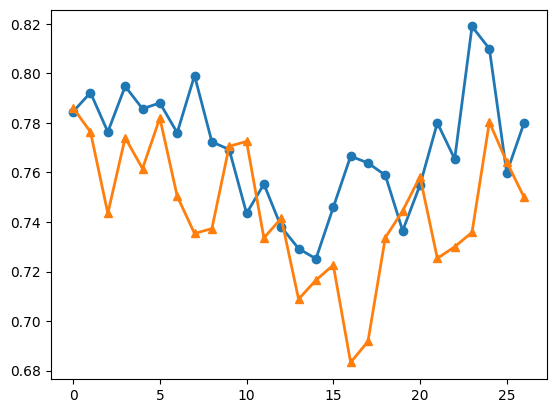

In [21]:
plt.plot(scores_train.keys(), [np.max(scores_train[ky]) for ky in scores_train.keys()], linewidth=2, marker='o')
plt.plot(scores_test.keys(), [scores_test[ky] for ky in scores_test.keys()], linewidth=2, marker='^')

#### predicted risk scores

In [29]:
preds_train = {}
surv_fn_train = {}
preds_test = {}
surv_fn_test = {}

for wk in weeks_range:
    start = time.perf_counter()

    estimator = best_estimators_gbm[wk]

    X_train = df_train_sets[df_train_sets.index.get_level_values(3) == wk][feature_cols]
    drop_cols = X_train.columns[X_train.isna().any()].tolist()
    X_train.drop(drop_cols, axis=1, inplace=True)
    X_train = pd.get_dummies(X_train, columns=['market_name'])
    y_train = df_train_sets[df_train_sets.index.get_level_values(3) == wk][target_cols].to_records(index=False)
    # scores_train[wk] = estimator.score(X_train[estimator.estimator.feature_names_in_], y_train)
    preds_train[wk] = estimator.predict(X_train[estimator.estimator.feature_names_in_])
    # surv_fn_train[wk] = estimator.predict_survival_function(X_train[estimator.estimator.feature_names_in_])

    X_test = df_test_sets[df_test_sets.index.get_level_values(3) == wk][feature_cols]
    X_test = pd.get_dummies(X_test, columns=['market_name'])
    missing_cols = list(set(estimator.estimator.feature_names_in_) - set(X_test.columns))
    print(missing_cols)
    for col in missing_cols:
        X_test[col] = 0
    X_test.drop(drop_cols, axis=1, inplace=True)
    test_idx = X_test[estimator.estimator.feature_names_in_].dropna().index
    y_test = df_test_sets[df_test_sets.index.get_level_values(3) == wk].loc[test_idx, target_cols].to_records(index=False)

    preds_test[wk] = estimator.predict(X_test[estimator.estimator.feature_names_in_].loc[test_idx])
    # surv_fn_test[wk] = estimator.predict_survival_function(X_test[estimator.estimator.feature_names_in_].loc[test_idx])

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['market_name_Minneapolis']
['market_name_Minneapolis']
['market_name_Minneapolis']
['market_name_Minneapolis']


In [24]:
preds_test[0]

array([ 0.57375898, -2.80654253,  1.69893977,  1.02453752,  0.60475597,
       -1.90918276,  1.14404742, -0.11740948,  0.57853978, -0.61876687,
        0.74223058, -0.07880826, -0.89507864, -2.59889605,  1.90722389,
        1.59792106,  0.43068381, -2.1385036 , -0.50830877, -1.48521653,
       -0.77369011, -0.56529163, -0.37362952,  4.18809402,  1.99139807,
       -1.23032491,  1.66757352, -2.3675691 ,  1.33553065, -0.07754147,
       -1.4215773 , -1.33136355, -0.03451458, -0.40130574, -2.22826945,
       -1.05382774, -0.36873097,  0.22078446,  3.0680384 , -0.50305279,
       -0.94317027,  2.17265699, -2.46029199, -2.53325269, -1.2129221 ,
        0.35048712,  1.28850433,  0.56623409, -0.96869534, -0.17916126,
       -1.4329015 ,  3.64670518, -2.17594047, -1.04155076,  2.60469922,
        1.51364543,  3.18834207, -1.24867781,  0.1330361 , -0.41470024,
       -1.03617717,  0.5229082 , -2.02256409, -0.8396726 ,  2.84799233,
       -0.69139631, -1.54963096,  2.39388392,  3.1970202 , -0.59

#### predicted survival curves and MAPE for survival time point prediction

In [9]:
from sksurv.functions import StepFunction
# define function to extract point estimate of survival time from survival curves
def get_percentile_from_step_fn(step_fns_list, percs):
    surv_time_preds=[]
    try:
        for step_fn in step_fns_list:
            idxs = [np.argmin(step_fn.y[step_fn.y >=alpha]) for alpha in percs]
            surv_time_pred = [step_fn.x[idx] for idx in idxs]
            surv_time_preds.append(surv_time_pred)
    except ValueError:
        return
    return surv_time_preds

In [11]:
def get_prob_from_step_fn(step_fns_list, spins):
    surv_time_preds=[]
    try:
        for step_fn in step_fns_list:
            idxs = [np.argmin(step_fn.x[step_fn.x >=alpha]) for alpha in spins]
            surv_time_pred = [step_fn.y[idx] for idx in idxs]
            surv_time_preds.append(surv_time_pred)
    except ValueError:
        return
    return surv_time_preds

In [14]:
df_surv_time = pd.DataFrame()
df_surv_time_test = pd.DataFrame()

df_surv_prob_test_all = pd.DataFrame()

for wk in weeks_range:
    start = time.perf_counter()

    estimator = best_estimators_gbm[wk]

    X_train = df_train_sets[df_train_sets.index.get_level_values(3) == wk][feature_cols]
    drop_cols = X_train.columns[X_train.isna().any()].tolist()
    X_train.drop(drop_cols, axis=1, inplace=True)
    X_train = pd.get_dummies(X_train, columns=['market_name'])
    y_train = df_train_sets[df_train_sets.index.get_level_values(3) == wk][target_cols].to_records(index=False)
    surv_fn_train = estimator.predict_survival_function(X_train[estimator.estimator.feature_names_in_])

    alphas = list(np.arange(0,1,0.1)) + [0.25, 0.50, 0.75, 0.95, 0.99]
    alphas = list(np.sort(alphas))
    # alphas = [0.25, 0.50, 0.75]
    surv_time_preds = get_percentile_from_step_fn(surv_fn_train, alphas)
    # df_surv_time_preds = pd.DataFrame(surv_time_preds, columns=['stp_perc_25', 'stp_perc_50', 'stp_perc_75'], index=X_train.index)
    df_surv_time_preds = pd.DataFrame(surv_time_preds, columns=[f'stp_perc_{int(100*i)}' for i in alphas], index=X_train.index)
    df_surv_time_preds = pd.concat([df_surv_time_preds, df_train_sets[df_train_sets.index.get_level_values(3) == wk][target_cols]], axis=1)
    df_surv_time = pd.concat([df_surv_time, df_surv_time_preds])

    X_test = df_test_sets[df_test_sets.index.get_level_values(3) == wk][feature_cols]
    X_test = pd.get_dummies(X_test, columns=['market_name'])
    missing_cols = list(set(estimator.estimator.feature_names_in_) - set(X_test.columns))
    print(missing_cols)
    for col in missing_cols:
        X_test[col] = 0
    test_idx = X_test[estimator.estimator.feature_names_in_].dropna().index
    y_test = df_test_sets[df_test_sets.index.get_level_values(3) == wk].loc[test_idx, target_cols].to_records(index=False)

    surv_fn_test = estimator.predict_survival_function(X_test[estimator.estimator.feature_names_in_].loc[test_idx])

    surv_time_preds_test = get_percentile_from_step_fn(surv_fn_test, alphas)
    # df_surv_time_preds_test = pd.DataFrame(surv_time_preds_test, columns=['stp_perc_25', 'stp_perc_50', 'stp_perc_75'], index=test_idx)
    df_surv_time_preds_test = pd.DataFrame(surv_time_preds_test, columns=[f'stp_perc_{int(100*i)}' for i in alphas], index=test_idx)
    df_surv_time_preds_test = pd.concat([df_surv_time_preds_test, df_test_sets[df_test_sets.index.get_level_values(3) == wk][target_cols]], axis=1)
    df_surv_time_test = pd.concat([df_surv_time_test, df_surv_time_preds_test])


    surv_prob_test = get_prob_from_step_fn(surv_fn_test, [25, 50, 75, 100])
    # df_surv_time_preds_test = pd.DataFrame(surv_time_preds_test, columns=['stp_perc_25', 'stp_perc_50', 'stp_perc_75'], index=test_idx)
    df_surv_prob_test = pd.DataFrame(surv_prob_test, columns=[f'prob_{int(i)}' for i in [25, 50, 75, 100]], index=test_idx)
    df_surv_prob_test = pd.concat([df_surv_prob_test, df_test_sets[df_test_sets.index.get_level_values(3) == wk][target_cols]], axis=1)
    df_surv_prob_test_all = pd.concat([df_surv_prob_test_all, df_surv_prob_test])

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['market_name_Minneapolis']
['market_name_Minneapolis']
['market_name_Minneapolis']
['market_name_Minneapolis']


In [16]:
df_surv_prob_test_all

,,,,prob_25,prob_50,prob_75,prob_100,censoring_flg_mod,target
mediabase_id,call_letters,week_dt,weeks_since_hit,,,,,,
2742545,KDHT-FM,2022-04-24,0.0,1.000000,1.000000,1.000000,1.000000,False,1515.0
2780771,KHTS-FM,2022-06-19,0.0,1.000000,1.000000,1.000000,1.000000,False,1491.0
2638380,WDCG-FM,2021-04-18,0.0,1.000000,1.000000,1.000000,1.000000,False,673.0
2345779,WKSC-FM,2021-02-28,0.0,1.000000,1.000000,1.000000,1.000000,False,208.0
2553815,WKSC-FM,2021-10-03,0.0,1.000000,1.000000,1.000000,1.000000,False,101.0
...,...,...,...,...,...,...,...,...,...
2552613,WZFT-FM,2020-10-11,26.0,0.995149,0.995149,0.995149,0.995149,True,176.0
2548688,KKRZ-FM,2020-09-13,26.0,0.994958,0.994958,0.994958,0.994958,True,492.0
2582475,KHTS-FM,2021-10-17,26.0,0.993022,0.993022,0.993022,0.993022,True,16.0


In [24]:
cols = [ col for col in df_surv_time[df_surv_time.index.get_level_values(3) <= 26].columns if 'stp_perc' in col]

In [48]:
df_train_sets.join(df_surv_time[cols], how='left')

artist_station_spins_am_pm_dr_13wk_lag2_mean  \
mediabase_id call_letters week_dt    weeks_since_hit                                                 
2591406      WNCI-FM      2021-09-26 0.0                                                 17.846154   
                          2021-10-03 1.0                                                 19.692308   
                          2021-10-10 2.0                                                 22.076923   
                          2021-10-17 3.0                                                 23.923077   
                          2021-10-24 4.0                                                 24.615385   
...                                                                                            ...   
2598403      WXKS-FM      2021-05-09 35.0                                                 0.923077   
                          2021-05-16 36.0                                                 0.846154   
                          2021-05-23 37.0                                                 0.846154   
                          2021-05-30 38.0                                                 0.769231   
                          2021-06-06 39.0                                                 0.692308   

                                                      instrumentalness  \
mediabase_id call_letters week_dt    weeks_since_hit                     
2591406      WNCI-FM      2021-09-26 0.0                      0.187540   
                          2021-10-03 1.0                      0.187540   
                          2021-10-10 2.0                      0.187540   
                          2021-10-17 3.0                      0.187540   
                          2021-10-24 4.0                      0.187540   
...                                                                ...   
2598403      WXKS-FM      2021-05-09 35.0                     0.045192   
                          2021-05-16 36.0                     0.045192   
                          2021-05-23 37.0                     0.045192   
                          2021-05-30 38.0                     0.045192   
                          2021-06-06 39.0                     0.045192   

                                                      artist_station_spins_non_on_4wk_lag2_min  \
mediabase_id call_letters week_dt    weeks_since_hit                                             
2591406      WNCI-FM      2021-09-26 0.0                                                  16.0   
                          2021-10-03 1.0                                                  21.0   
                          2021-10-10 2.0                                                  21.0   
                          2021-10-17 3.0                                                  21.0   
                          2021-10-24 4.0                                                  34.0   
...                                                                                        ...   
2598403      WXKS-FM      2021-05-09 35.0                                                  0.0   
                          2021-05-16 36.0                                                  0.0   
                          2021-05-23 37.0                                                  0.0   
                          2021-05-30 38.0                                                  0.0   
                          2021-06-06 39.0                                                  0.0   

                                                      artist_format_ddl_4wk_lag1_mean  \
mediabase_id call_letters week_dt    weeks_since_hit                                    
2591406      WNCI-FM      2021-09-26 0.0                                        12.50   
                          2021-10-03 1.0                                        12.00   
                          2021-10-10 2.0                                        11.75   
                          2021-10-17 3.0    

In [117]:
df_surv_time = df_surv_time.assign(**{'APE_25': np.abs((df_surv_time['stp_perc_25'] - df_surv_time['target'])/df_surv_time['target']),
                     'APE_50': np.abs((df_surv_time['stp_perc_50'] - df_surv_time['target'])/df_surv_time['target']),
                     'APE_75': np.abs((df_surv_time['stp_perc_75'] - df_surv_time['target'])/df_surv_time['target'])})

ValueError: cannot join with no overlapping index names

In [126]:
df_surv_time[(df_surv_time.index.get_level_values(3) <= 26) & (df_surv_time['censoring_flg_mod'] == True)].apply(lambda x: np.abs((x['stp_perc_75'] - x['target'])/x['target']), axis=1).median()

0.41397849462365593

In [129]:
df_surv_time_test[(df_surv_time_test.index.get_level_values(3) <= 26) & (df_surv_time_test['censoring_flg_mod'] == True)].apply(lambda x: np.abs((x['stp_perc_50'] - x['target'])/x['target']), axis=1).mean()

stp_perc_50    3.050902
stp_perc_50    3.050902
dtype: float64

In [111]:
df_surv_time_test = df_surv_time_test.assign(**{'APE_25': np.abs((df_surv_time_test['stp_perc_25'] - df_surv_time_test['target'])/df_surv_time_test['target']),
                     'APE_50': np.abs((df_surv_time_test['stp_perc_50'] - df_surv_time_test['target'])/df_surv_time_test['target']),
                     'APE_75': np.abs((df_surv_time_test['stp_perc_75'] - df_surv_time_test['target'])/df_surv_time_test['target'])})

ValueError: cannot join with no overlapping index names

In [110]:
df_surv_time.groupby(['censoring_flg_mod']).agg({'APE_25':np.median, 'APE_50':np.median, 'APE_75':np.median})

SpecificationError: Column(s) ['APE_25', 'APE_50', 'APE_75'] do not exist

In [100]:
df_surv_time_test[df_surv_time_test['target'] <= 100].groupby(['weeks_since_hit', 'censoring_flg_mod']).agg({'APE_25':np.median, 'APE_50':np.median, 'APE_75':np.median})

APE_25     APE_50     APE_75
weeks_since_hit censoring_flg_mod                                  
0.0             False                9.996872   6.839625   4.431083
                True                 6.673771   4.462366   2.666283
1.0             False               10.200000   8.000000   5.294737
                True                 7.515110   4.857143   2.293956
2.0             False               14.331170  10.720970   6.323115
                True                10.666180   6.849003   3.484330
3.0             False               13.119048   9.404762   5.357143
                True                 9.710526   7.015789   3.744168
4.0             False               13.128205   8.948718   4.666667
                True                 5.238095   3.119048   1.428571
5.0             False               14.117021  10.278284   5.843803
                True                 6.261538   3.586207   1.425287
6.0             False               19.113566  11.477907   5.023256
                True                 7.575758   4.186047   1.424242
7.0             False               15.585586  10.283333   5.866667
                True                 5.188235   4.046875   2.156250
8.0             False               22.426667  14.466667   6.460000
                True                 6.707773   3.720370   1.295690
9.0             False               17.400000  13.138462   7.800000
                True                 4.844097   2.738889   1.104688
10.0            False               23.298583  15.294231   8.291466
                True                 7.531513   4.383746   1.931066
11.0            False               19.427083  12.471354   7.968203
                True                 4.545322   2.684211   0.943750
12.0            False               32.166667  16.400000   7.743590
                True                 5.031093   2.923001   0.757152
13.0            False               25.462963  15.996032   7.658065
                True                 5.595238   3.047619   0.785714
14.0            False               41.016667  23.641026  10.839744
                True                10.187500   5.962500   2.378571
15.0            False               42.200000  30.000000  15.800000
                True                 5.882353   3.413793   1.586207
16.0            False               94.100000  43.450000  17.100000
                True                22.442460  10.727778   3.772619
17.0            False               40.666667  26.000000  16.166667
                True                 8.646739   5.706522   3.093268
18.0            False               31.562500  24.125000  17.800000
                True                 7.838710   5.677419   3.225806
19.0            False               41.836538  23.750000  13.500000
                True                 9.202183   5.836279   2.510915
20.0            False               51.200000  32.200000  15.000000
                True                 7.767857   4.178571   1.946429
21.0            False              126.222222  43.555556  16.277778
                True                24.097561   7.555556   2.400000
22.0            False               49.625000  39.625000  27.125000
                True                 5.485294   3.903935   2.443900
23.0            False              158.857143  53.285714  18.000000
                True                25.760453   8.048200   2.193089
24.0            False              158.714286  53.142857  20.285714
                True                38.337037  12.335185   4.242593
25.0            False               92.400000  49.075000  23.700000
                True                17.214286   8.464286   3.500000
26.0            False              120.250000  50.888889  19.375000
                True                27.914348   9.505652   3.699130

In [101]:
df_surv_time_test[df_surv_time_test['target'] <= 100]

,,,,stp_perc_25,stp_perc_50,stp_perc_75,censoring_flg_mod,target,APE_25,APE_50,APE_75
mediabase_id,call_letters,week_dt,weeks_since_hit,,,,,,,,
2638380,KYLD-FM,2021-03-21,0.0,614.0,458.0,309.0,False,91.0,5.747253,4.032967,2.395604
2440816,WKFS-FM,2021-01-10,0.0,726.0,519.0,360.0,False,61.0,10.901639,7.508197,4.901639
2695921,WKQI-FM,2022-01-16,0.0,240.0,166.0,108.0,False,59.0,3.067797,1.813559,0.830508
2541634,WKST-FM,2021-01-03,0.0,364.0,262.0,162.0,False,8.0,44.500000,31.750000,19.250000
2615043,KHFI-FM,2021-06-13,0.0,304.0,207.0,138.0,False,60.0,4.066667,2.450000,1.300000
...,...,...,...,...,...,...,...,...,...,...,...
2553815,KKRZ-FM,2020-10-11,26.0,556.0,271.0,106.0,True,46.0,11.086957,4.891304,1.304348
2568955,WKQI-FM,2021-05-16,26.0,952.0,374.0,159.0,True,81.0,10.753086,3.617284,0.962963
2550239,KIIS-FM,2021-02-07,26.0,872.0,329.0,137.0,True,67.0,12.014925,3.910448,1.044776


In [47]:
df_test_sets

artist_station_spins_am_pm_dr_13wk_lag2_mean  \
mediabase_id call_letters week_dt    weeks_since_hit                                                 
2742545      KDHT-FM      2022-04-24 0.0                                                 81.500000   
                          2022-05-01 1.0                                                 81.400000   
                          2022-05-08 2.0                                                 80.500000   
                          2022-05-15 3.0                                                 81.285714   
                          2022-05-22 4.0                                                 82.500000   
...                                                                                            ...   
2584541      WDCG-FM      2021-06-13 1.0                                                 56.846154   
                          2021-06-20 2.0                                                 56.923077   
                          2021-06-27 3.0                                                 57.923077   
                          2021-07-04 4.0                                                 61.923077   
                          2021-07-11 5.0                                                 65.230769   

                                                      instrumentalness  \
mediabase_id call_letters week_dt    weeks_since_hit                     
2742545      KDHT-FM      2022-04-24 0.0                      0.111254   
                          2022-05-01 1.0                      0.111254   
                          2022-05-08 2.0                      0.111254   
                          2022-05-15 3.0                      0.111254   
                          2022-05-22 4.0                      0.111254   
...                                                                ...   
2584541      WDCG-FM      2021-06-13 1.0                      0.046758   
                          2021-06-20 2.0                      0.046758   
                          2021-06-27 3.0                      0.046758   
                          2021-07-04 4.0                      0.046758   
                          2021-07-11 5.0                      0.046758   

                                                      artist_station_spins_non_on_4wk_lag2_min  \
mediabase_id call_letters week_dt    weeks_since_hit                                             
2742545      KDHT-FM      2022-04-24 0.0                                                  76.0   
                          2022-05-01 1.0                                                 111.0   
                          2022-05-08 2.0                                                 101.0   
                          2022-05-15 3.0                                                 101.0   
                          2022-05-22 4.0                                                 101.0   
...                                                                                        ...   
2584541      WDCG-FM      2021-06-13 1.0                                                  96.0   
                          2021-06-20 2.0                                                  80.0   
                          2021-06-27 3.0                                                  80.0   
                          2021-07-04 4.0                                                  80.0   
                          2021-07-11 5.0                                                  80.0   

                                                      artist_format_ddl_4wk_lag1_mean  \
mediabase_id call_letters week_dt    weeks_since_hit                                    
2742545      KDHT-FM      2022-04-24 0.0                                    16.000000   
                          2022-05-01 1.0                                    16.250000   
                          2022-05-08 2.0                                    16.500000   
                          2022-05-15 3.0    

#### Examine Confusion Matrix

In [30]:
df_train_sets['pred'] = np.nan
df_test_sets['pred'] = np.nan

In [19]:
df_train_sets.columns

Index(['artist_station_spins_am_pm_dr_13wk_lag2_mean', 'instrumentalness',
       'artist_station_spins_non_on_4wk_lag2_min',
       'artist_format_ddl_4wk_lag1_mean', 'thumbs_down_count_26wk_lag2_max',
       'station_spins_ddl_sens_26wk_lag1_min',
       'artist_format_spins_am_pm_dr_26wk_lag2_mean',
       'stream_count_26wk_lag2_max',
       'artist_station_spins_non_on_13wk_lag2_min',
       'artist_market_spins_non_on_13wk_lag1_min',
       ...
       'artist_format_spins_am_pm_dr_26wk_lag2_min',
       'song_station_ddl_26wk_lag1_min', 'ddl_quintile_2-4_apps_lag1',
       'completed_count_1wk_lag1_mean',
       'song_market_spins_non_on_13wk_lag2_mean',
       'song_station_spins_non_on_delta_4wk_lag2_max',
       'station_spins_ddl_sens_abs_13wk_lag2_max', 'censoring_flg_mod',
       'target', 'pred'],
      dtype='object', length=1135)

In [31]:
for wk in weeks_range:
    # print(df_train_sets[df_train_sets.index.get_level_values(3) == wk].shape)
    df_train_sets.loc[df_train_sets.index.get_level_values(3) == wk, 'pred'] = preds_train[wk]
    df_test_sets.loc[df_test_sets.index.get_level_values(3) == wk, 'pred'] = preds_test[wk]
    # print(len(preds_train[wk]))

In [76]:
df_sub = df_test_sets[(df_test_sets.index.get_level_values(3) == 15) & (df_test_sets['censoring_flg_mod'] == False)].sort_values(by=['target'])

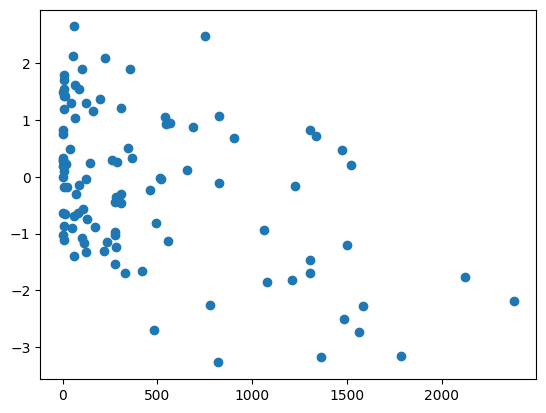

In [77]:
import matplotlib.pyplot as plt
plt.scatter(df_sub['target'], df_sub['pred'])

In [134]:
df_train_sets['pred_quintile'] = df_train_sets.groupby(['weeks_since_hit', 'censoring_flg_mod']).apply(lambda x: pd.qcut(x['pred'], q=5, labels=False)).droplevel([0,1])
df_test_sets['pred_quintile'] = df_test_sets.groupby(['weeks_since_hit', 'censoring_flg_mod']).apply(lambda x: pd.qcut(x['pred'], q=5, labels=False)).droplevel([0,1])

ValueError: Bin edges must be unique: array([nan, nan, nan, nan, nan, nan]).
You can drop duplicate edges by setting the 'duplicates' kwarg

In [31]:
df_train_sets['target_quintile'] = df_train_sets.groupby(['weeks_since_hit', 'censoring_flg_mod']).apply(lambda x: pd.qcut(x['target'], q=5, labels=[4,3,2,1,0])).droplevel([0,1])

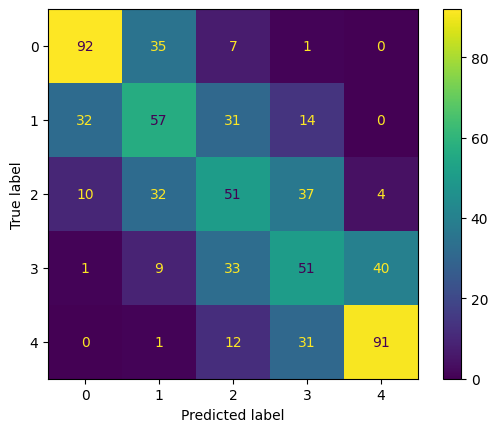

In [36]:
from sklearn.metrics import  ConfusionMatrixDisplay, confusion_matrix
preds = df_train_sets.loc[(df_train_sets.index.get_level_values(3)==4) & (df_train_sets['censoring_flg_mod'] == True)]['pred_quintile']
true = df_train_sets.loc[(df_train_sets.index.get_level_values(3)==4) & (df_train_sets['censoring_flg_mod'] == True)]['target_quintile']
cm= confusion_matrix(true, preds, labels=[0,1,2,3,4])
cf = ConfusionMatrixDisplay(cm)
cf.from_predictions(true, preds)

In [38]:
cm

array([[92, 35,  7,  1,  0],
       [32, 57, 31, 14,  0],
       [10, 32, 51, 37,  4],
       [ 1,  9, 33, 51, 40],
       [ 0,  1, 12, 31, 91]])

#### Explore time-dependent AUC

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['market_name_Minneapolis']
['market_name_Minneapolis']
['market_name_Minneapolis']
['market_name_Minneapolis']


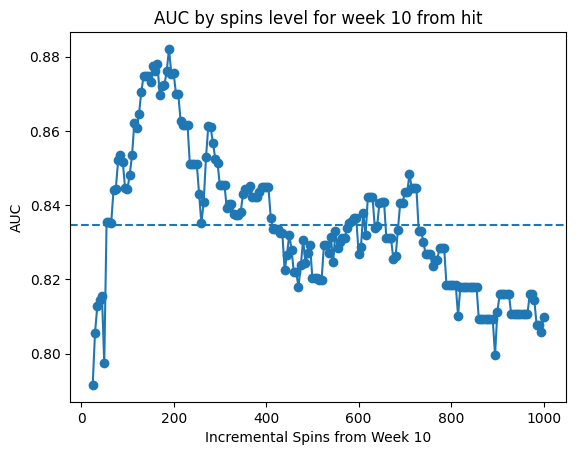

In [10]:
from sksurv.metrics import cumulative_dynamic_auc
times = np.arange(25,1005, 5)
times_2 = np.arange(25,505, 5)
mean_auc_wk = {}
for wk in weeks_range:
    start = time.perf_counter()

    estimator = best_estimators_gbm[wk]

    X_train = df_train_sets[df_train_sets.index.get_level_values(3) == wk][feature_cols]
    drop_cols = X_train.columns[X_train.isna().any()].tolist()
    X_train.drop(drop_cols, axis=1, inplace=True)
    X_train = pd.get_dummies(X_train, columns=['market_name'])
    y_train = df_train_sets[df_train_sets.index.get_level_values(3) == wk][target_cols].to_records(index=False)


    X_test = df_test_sets[df_test_sets.index.get_level_values(3) == wk][feature_cols]
    X_test = pd.get_dummies(X_test, columns=['market_name'])
    missing_cols = list(set(estimator.estimator.feature_names_in_) - set(X_test.columns))
    print(missing_cols)
    for col in missing_cols:
        X_test[col] = 0

    test_idx = X_test[estimator.estimator.feature_names_in_].dropna().index
    y_test = df_test_sets[df_test_sets.index.get_level_values(3) == wk].loc[test_idx, target_cols].to_records(index=False)

    risk_scores = estimator.predict(X_test.loc[test_idx, estimator.estimator.feature_names_in_])
    if wk <= 15:
        roc_auc, mean_auc=cumulative_dynamic_auc(y_train, y_test, risk_scores, times)
        if wk == 10:
            plt.plot(times, roc_auc, marker='o')
            plt.axhline(mean_auc, linestyle='--')
            plt.title('AUC by spins level for week 10 from hit')
            plt.xlabel('Incremental Spins from Week 10')
            plt.ylabel('AUC')
            plt.savefig('AUC_week_10.jpeg', format='jpeg')
    else:
        roc_auc, mean_auc=cumulative_dynamic_auc(y_train, y_test, risk_scores, times_2)
        # plt.plot(times_2, roc_auc, marker='o')
        # plt.axhline(mean_auc, linestyle='--')
        # plt.show()

    mean_auc_wk[wk] = mean_auc

Text(0, 0.5, 'Area under ROC Curve')

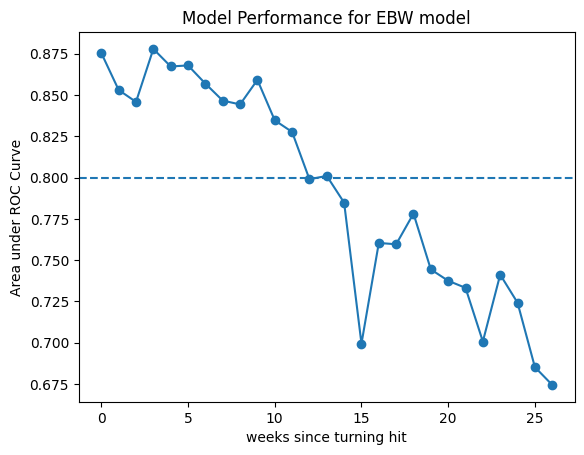

In [11]:
plt.plot(mean_auc_wk.keys(), [mean_auc_wk[i] for i in mean_auc_wk.keys()], marker = 'o')
plt.axhline(y=0.8, linestyle='--')
plt.title('Model Performance for EBW model')
plt.xlabel('weeks since turning hit')
plt.ylabel('Area under ROC Curve')
# plt.savefig('ebw_auc_h1.jpeg', format='jpeg', dpi=300)

In [30]:
df_rep = df_train_sets.groupby(['weeks_since_hit', 'censoring_flg_mod'])[['target']].count().join(df_test_sets.groupby(['weeks_since_hit', 'censoring_flg_mod'])['target'].count(), rsuffix='_r')
df_rep.columns=['train_samples', 'test_samples']

In [31]:
df_rep_pvt = df_rep.reset_index().pivot_table(index=['weeks_since_hit'], columns=['censoring_flg_mod'], values=['train_samples', 'test_samples'])

In [32]:
df_rep_pvt.columns = ['test_samples_False', 'test_samples_True', 'train_samples_False', 'train_samples_True']

In [34]:
df_rep_pvt.reset_index().to_excel('samples_ebw.xlsx')

In [41]:
df_rep_pvt = df_rep_pvt[df_rep_pvt.index.get_level_values(0) <= 26]

In [43]:
df_rep_pvt

test_samples        train_samples       
censoring_flg_mod        False  True          False  True 
weeks_since_hit                                           
0.0                      103.0  239.0         305.0  717.0
1.0                      103.0  239.0         305.0  717.0
2.0                      103.0  234.0         305.0  706.0
3.0                      103.0  234.0         305.0  699.0
4.0                      103.0  225.0         305.0  671.0
5.0                      103.0  222.0         304.0  655.0
6.0                      103.0  207.0         304.0  624.0
7.0                      103.0  202.0         302.0  598.0
8.0                      103.0  193.0         302.0  563.0
9.0                      103.0  188.0         300.0  543.0
10.0                     103.0  173.0         300.0  495.0
11.0                     103.0  164.0         300.0  470.0
12.0                     103.0  151.0         300.0  436.0
13.0                     102.0  141.0         300.0  405.0
14.0                     102.0  134.0         300.0  371.0
15.0                     102.0  123.0         300.0  353.0
16.0                     102.0  113.0         299.0  325.0
17.0                     102.0  107.0         299.0  298.0
18.0                     102.0   97.0         299.0  277.0
19.0                     102.0   87.0         299.0  256.0
20.0                     102.0   76.0         298.0  243.0
21.0                     102.0   74.0         298.0  224.0
22.0                     102.0   66.0         297.0  203.0
23.0                     100.0   61.0         296.0  193.0
24.0                      99.0   55.0         295.0  173.0
25.0                      98.0   52.0         294.0  164.0
26.0                      98.0   47.0         293.0  147.0

In [116]:
df_rep_pvt.reset_index(inplace=True)

In [118]:
df_rep_pvt['weeks_since_hit'] = df_rep_pvt['weeks_since_hit'].astype(int)

<AxesSubplot:>

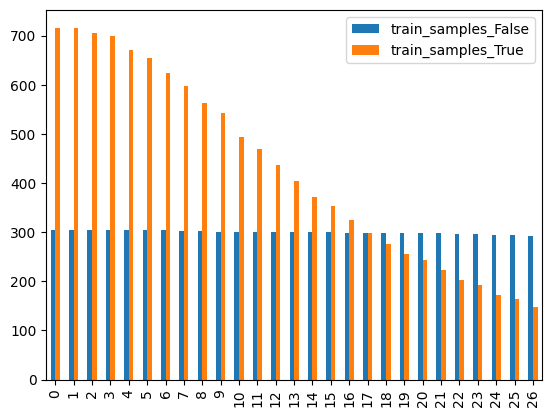

In [123]:
df_rep_pvt[['train_samples_False', 'train_samples_True']]

##### Burn rate chart

In [34]:
df_train_sets

artist_station_spins_am_pm_dr_13wk_lag2_mean  \
mediabase_id call_letters week_dt    weeks_since_hit                                                 
2591406      WNCI-FM      2021-09-26 0.0                                                 17.846154   
                          2021-10-03 1.0                                                 19.692308   
                          2021-10-10 2.0                                                 22.076923   
                          2021-10-17 3.0                                                 23.923077   
                          2021-10-24 4.0                                                 24.615385   
...                                                                                            ...   
2598403      WXKS-FM      2021-02-07 22.0                                                21.307692   
                          2021-02-14 23.0                                                17.538462   
                          2021-02-21 24.0                                                13.769231   
                          2021-02-28 25.0                                                10.230769   
                          2021-03-07 26.0                                                 6.384615   

                                                      instrumentalness  \
mediabase_id call_letters week_dt    weeks_since_hit                     
2591406      WNCI-FM      2021-09-26 0.0                      0.187540   
                          2021-10-03 1.0                      0.187540   
                          2021-10-10 2.0                      0.187540   
                          2021-10-17 3.0                      0.187540   
                          2021-10-24 4.0                      0.187540   
...                                                                ...   
2598403      WXKS-FM      2021-02-07 22.0                     0.045192   
                          2021-02-14 23.0                     0.045192   
                          2021-02-21 24.0                     0.045192   
                          2021-02-28 25.0                     0.045192   
                          2021-03-07 26.0                     0.045192   

                                                      artist_station_spins_non_on_4wk_lag2_min  \
mediabase_id call_letters week_dt    weeks_since_hit                                             
2591406      WNCI-FM      2021-09-26 0.0                                                  16.0   
                          2021-10-03 1.0                                                  21.0   
                          2021-10-10 2.0                                                  21.0   
                          2021-10-17 3.0                                                  21.0   
                          2021-10-24 4.0                                                  34.0   
...                                                                                        ...   
2598403      WXKS-FM      2021-02-07 22.0                                                  0.0   
                          2021-02-14 23.0                                                  0.0   
                          2021-02-21 24.0                                                  0.0   
                          2021-02-28 25.0                                                  0.0   
                          2021-03-07 26.0                                                  0.0   

                                                      artist_format_ddl_4wk_lag1_mean  \
mediabase_id call_letters week_dt    weeks_since_hit                                    
2591406      WNCI-FM      2021-09-26 0.0                                    12.500000   
                          2021-10-03 1.0                                    12.000000   
                          2021-10-10 2.0                                    11.750000   
                          2021-10-17 3.0    

In [137]:
df_test_sets[(df_test_sets.index.get_level_values(3) <= 26) & (~pd.isna(df_test_sets['pred']))]

artist_station_spins_am_pm_dr_13wk_lag2_mean  \
mediabase_id call_letters week_dt    weeks_since_hit                                                 
2742545      KDHT-FM      2022-04-24 0.0                                                 81.500000   
                          2022-05-01 1.0                                                 81.400000   
                          2022-05-08 2.0                                                 80.500000   
                          2022-05-15 3.0                                                 81.285714   
                          2022-05-22 4.0                                                 82.500000   
...                                                                                            ...   
2584541      WDCG-FM      2021-06-13 1.0                                                 56.846154   
                          2021-06-20 2.0                                                 56.923077   
                          2021-06-27 3.0                                                 57.923077   
                          2021-07-04 4.0                                                 61.923077   
                          2021-07-11 5.0                                                 65.230769   

                                                      instrumentalness  \
mediabase_id call_letters week_dt    weeks_since_hit                     
2742545      KDHT-FM      2022-04-24 0.0                      0.111254   
                          2022-05-01 1.0                      0.111254   
                          2022-05-08 2.0                      0.111254   
                          2022-05-15 3.0                      0.111254   
                          2022-05-22 4.0                      0.111254   
...                                                                ...   
2584541      WDCG-FM      2021-06-13 1.0                      0.046758   
                          2021-06-20 2.0                      0.046758   
                          2021-06-27 3.0                      0.046758   
                          2021-07-04 4.0                      0.046758   
                          2021-07-11 5.0                      0.046758   

                                                      artist_station_spins_non_on_4wk_lag2_min  \
mediabase_id call_letters week_dt    weeks_since_hit                                             
2742545      KDHT-FM      2022-04-24 0.0                                                  76.0   
                          2022-05-01 1.0                                                 111.0   
                          2022-05-08 2.0                                                 101.0   
                          2022-05-15 3.0                                                 101.0   
                          2022-05-22 4.0                                                 101.0   
...                                                                                        ...   
2584541      WDCG-FM      2021-06-13 1.0                                                  96.0   
                          2021-06-20 2.0                                                  80.0   
                          2021-06-27 3.0                                                  80.0   
                          2021-07-04 4.0                                                  80.0   
                          2021-07-11 5.0                                                  80.0   

                                                      artist_format_ddl_4wk_lag1_mean  \
mediabase_id call_letters week_dt    weeks_since_hit                                    
2742545      KDHT-FM      2022-04-24 0.0                                    16.000000   
                          2022-05-01 1.0                                    16.250000   
                          2022-05-08 2.0                                    16.500000   
                          2022-05-15 3.0    

In [37]:
mask_missing_preds = ~pd.isna(df_test_sets['pred'])
df_test_sets.loc[mask_missing_preds]

artist_station_spins_am_pm_dr_13wk_lag2_mean  \
mediabase_id call_letters week_dt    weeks_since_hit                                                 
2742545      KDHT-FM      2022-04-24 0.0                                                 81.500000   
                          2022-05-01 1.0                                                 81.400000   
                          2022-05-08 2.0                                                 80.500000   
                          2022-05-15 3.0                                                 81.285714   
                          2022-05-22 4.0                                                 82.500000   
...                                                                                            ...   
2584541      WDCG-FM      2021-06-13 1.0                                                 56.846154   
                          2021-06-20 2.0                                                 56.923077   
                          2021-06-27 3.0                                                 57.923077   
                          2021-07-04 4.0                                                 61.923077   
                          2021-07-11 5.0                                                 65.230769   

                                                      instrumentalness  \
mediabase_id call_letters week_dt    weeks_since_hit                     
2742545      KDHT-FM      2022-04-24 0.0                      0.111254   
                          2022-05-01 1.0                      0.111254   
                          2022-05-08 2.0                      0.111254   
                          2022-05-15 3.0                      0.111254   
                          2022-05-22 4.0                      0.111254   
...                                                                ...   
2584541      WDCG-FM      2021-06-13 1.0                      0.046758   
                          2021-06-20 2.0                      0.046758   
                          2021-06-27 3.0                      0.046758   
                          2021-07-04 4.0                      0.046758   
                          2021-07-11 5.0                      0.046758   

                                                      artist_station_spins_non_on_4wk_lag2_min  \
mediabase_id call_letters week_dt    weeks_since_hit                                             
2742545      KDHT-FM      2022-04-24 0.0                                                  76.0   
                          2022-05-01 1.0                                                 111.0   
                          2022-05-08 2.0                                                 101.0   
                          2022-05-15 3.0                                                 101.0   
                          2022-05-22 4.0                                                 101.0   
...                                                                                        ...   
2584541      WDCG-FM      2021-06-13 1.0                                                  96.0   
                          2021-06-20 2.0                                                  80.0   
                          2021-06-27 3.0                                                  80.0   
                          2021-07-04 4.0                                                  80.0   
                          2021-07-11 5.0                                                  80.0   

                                                      artist_format_ddl_4wk_lag1_mean  \
mediabase_id call_letters week_dt    weeks_since_hit                                    
2742545      KDHT-FM      2022-04-24 0.0                                    16.000000   
                          2022-05-01 1.0                                    16.250000   
                          2022-05-08 2.0                                    16.500000   
                          2022-05-15 3.0    

In [38]:
df_train_sets.loc[:, 'pred_quintile'] = df_train_sets.groupby(['weeks_since_hit', 'censoring_flg_mod']).apply(lambda x: pd.qcut(x['pred'], q=5, labels=False)).droplevel([0,1])

In [39]:
df_train_sets.loc[:, 'pred_quintile_all'] = df_train_sets.groupby(['weeks_since_hit']).apply(
    lambda x: pd.qcut(x['pred'], q=5, labels=False)).droplevel([0])

In [41]:
df_test_sets.loc[:, 'pred_quintile'] = df_test_sets.groupby(['weeks_since_hit', 'censoring_flg_mod']).apply(lambda x: pd.qcut(x['pred'], q=5, labels=False)).droplevel([0,1])

In [42]:
df_test_sets.loc[:, 'pred_quintile_all'] = df_test_sets.groupby(['weeks_since_hit']).apply(lambda x: pd.qcut(x['pred'], q=5, labels=False)).droplevel([0])

In [48]:
from sqlalchemy import create_engine


def postgresql_engine(user, pwd, host, port, dbname):
    # Need psycopg2-binary package
    sql_engine = create_engine('postgres://' + user + ':' + pwd + '@' + host + ':' + port + '/' + dbname, echo=False)
    return sql_engine


# DB username & password
import getpass

username = getpass.getpass()
password = getpass.getpass()


# misc db parameters
url = 'adds-postgres-dev.cfgztrijqgvp.us-east-1.rds.amazonaws.com'
database = 'musiclab'
port = '5432'

#create db engine
engine = postgresql_engine(username, password, url, port, database)

In [49]:
sql_cols = ['pred', 'target','censoring_flg_mod', 'pred_quintile', 'pred_quintile_all']
with engine.connect() as conn:
    with conn.begin():
        df_train_sets[sql_cols].to_sql('ebw_train_set_h1', con=conn, schema='adds_temp', method='multi')
        df_test_sets[sql_cols].to_sql('ebw_test_set_h1', con=conn, schema='adds_temp', method='multi')

In [46]:
df_sub = df_test_sets

In [29]:
df_sub.groupby(['weeks_since_hit', 'pred_quintile_all', 'censoring_flg_mod'])[['target']].count().join(df_sub.groupby(['weeks_since_hit', 'pred_quintile_all', 'censoring_flg_mod'])['target'].mean(), rsuffix='_r').reset_index().to_excel('test_target_h1.xlsx')

In [27]:
df_sub.groupby(['weeks_since_hit', 'pred_quintile_all'])[['target']].count().join(df_sub.groupby(['weeks_since_hit', 'pred_quintile_all'])['target'].mean(), rsuffix='_r')

target     target_r
weeks_since_hit pred_quintile_all                     
0.0             0.0                    69  1594.043478
                1.0                    68  1323.955882
                2.0                    68   896.558824
                3.0                    68   589.014706
                4.0                    69   309.637681
...                                   ...          ...
26.0            0.0                    29   598.034483
                1.0                    29   176.275862
                2.0                    29   169.827586
                3.0                    29   125.379310
                4.0                    29   317.448276

[135 rows x 2 columns]

In [ ]:
df_sub.groupby(['weeks_since_hit', 'pred_quintile'])[['burn_before_100_flg']].count().join(df_sub.groupby(['weeks_since_hit', 'pred_quintile'])['burn_before_100_flg'].sum(), rsuffix='_r')

#### Spins to burn min analysis

In [66]:
df_expt = df_train_sets.join(df_surv_time[cols], how='inner')
idx = df_expt[cols].dropna().index
df_expt = df_expt.loc[idx]

In [69]:
df_expt.groupby(['weeks_since_hit'])['target'].count()

weeks_since_hit
0.0     1022
1.0     1022
2.0     1011
3.0     1004
6.0      928
14.0     671
16.0     624
18.0     576
19.0     555
20.0     541
21.0     522
23.0     489
24.0     468
Name: target, dtype: int64

In [79]:
for col in cols:
    try:
        df_expt[col + '_diff'] = df_expt.apply(lambda x: np.abs((x[col]/x['target']) - 1), axis=1)
    except ValueError:
        continue

In [82]:
diff_cols = [col for col in df_expt.columns if 'diff' in col]

In [88]:
df_expt_sub = df_expt[df_expt['censoring_flg_mod'] == True]

ValueError: cannot reindex from a duplicate axis

In [91]:
df_expt_sub.reset_index(inplace=True)

In [109]:
df_expt_sub.groupby(['weeks_since_hit', 'pred_quintile'])['target'].agg([np.mean, np.median, lambda x: np.percentile(x, 90), lambda x: np.percentile(x, 10)])

mean  median  <lambda_0>  <lambda_1>
weeks_since_hit pred_quintile                                             
0.0             0.0            1740.673611  1751.0      2160.0      1313.3
                1.0            1192.594406  1182.0      1453.6       959.0
                2.0             838.755245   880.0      1081.8       513.8
                3.0             556.041958   554.0       792.6       331.0
                4.0             216.006944   188.0       398.1        58.2
...                                    ...     ...         ...         ...
24.0            0.0             474.114286   366.0      1019.2       141.2
                1.0             294.558824   275.5       594.1        41.2
                2.0             159.371429    73.0       305.0         9.4
                3.0             213.764706   165.5       425.5        17.6
                4.0             129.171429    86.0       307.4        19.4

[65 rows x 4 columns]